In [1]:
%reset -f
import msprime
import tskit 
import SpARG
import numpy as np 
import pyslim
import matplotlib.pyplot as plt
import importlib
importlib.reload(SpARG);

In [12]:
def Tree_estimates(ts): 
    # S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    S = list(ts.samples())
    breakpoints = list(ts.breakpoints())
    # print(breakpoints)
    n_breakpoints = len(breakpoints)
    mu_list = [] 
    sigma_list = []
    for i in range(n_breakpoints -1):  
        tree = ts.keep_intervals( np.array([[breakpoints[i],breakpoints[i+1]]]), simplify=False ) 
        tree = tree.rtrim()
        mu, sigma = SpARG.ARG_estimate(tree)
        mu_list += [ mu[0][0] ]
        sigma_list += [sigma[0][0]]
        
    return mu_list, sigma_list 

def Wilder_Wohns_mu(ts, weighted = True): 
    S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    loc = {i:ts.individuals()[i].location[0] for i in S} 
    time = {nd.id:nd.time for nd in ts.nodes() }
    for nd in ts.nodes(): 
        if nd.flags == 1 : 
            continue
        children = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd.id)]
        for child in children:
            if time[child] == time[nd.id]: 
                raise TypeError('Error',nd,child,time[child],time[nd.id])
        wghts = [1 for child in children]
        if weighted: 
            wghts =  [ 1.0/(time[nd.id] - time[child]) for child in children ]
            time[nd.id] -= 1.0/sum(wghts) 
        loc[nd.id] = np.average( [ loc[child] for child in children ] , weights = wghts)
    GMRCA = max( ts.nodes(), key = lambda nd : nd.id ) 
    return loc[GMRCA.id]


In [13]:
def ts_bubble( start=0.01, x = 0.25, t=1 ):     
    ts_bubble = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_bubble.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, start*t, start*t, (start+x)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_bubble.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_bubble.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 0.0]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 5, 4, 4, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_bubble.sort()
    return ts_bubble.tree_sequence()

x_range = np.arange(0.01,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_bubble(x=x)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(1,2) 
ax[0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Single Isolated Loop (Bubble)', fontsize = 17)
fig.set_size_inches([10,4])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.898, wspace=0.3, hspace=0.405)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)


ValueError: too many values to unpack (expected 2)

In [14]:
def ts_singlecompound(x=0.25, y=0.125, t=1 ):     
    ts_singlecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 5e2]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 4, 4, 5, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound.sort()
    return ts_singlecompound.tree_sequence()

x_range = np.arange(0.126,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_singlecompound(x=x)
    # print(x)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(2,2) 
ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
""" ---------------- """
y_range = np.arange(0.01,0.48,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound(x=0.5, y=y)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[1][0].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
ax[1][1].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Single Compound Loop', fontsize = 17)
fig.set_size_inches([10,8])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.898, wspace=0.3, hspace=0.3)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)


ValueError: too many values to unpack (expected 2)

In [15]:
def ts_doublecompound(x=0.75, y=0.5, z = 0.4, w = 0.2, t=1): 
    ts_doublecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_doublecompound.nodes
    node_table.set_columns(
        # flags = np.array([1, 1, 131072, 131072,0, 131072, 131072, 0 ,0], dtype=np.uint32),
        flags = np.array([1, 1, 0, 0,0, 0, 0, 0 ,0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, (1-z)*t, (1-z)*t, (1-w)*t, t ]),
        individual = np.array(list(range(2)) + [-1 for i in range(7)], dtype = np.int32)
    )
    
    individual_table = ts_doublecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_doublecompound.edges
    edge_table.set_columns(
        right=np.array([3e2, 1e3, 1e3, 3e2, 6e2, 1e3, 1e3, 6e2, 1e3, 6e2]),
        left=np.array([0.0, 3e2, 0.0, 0.0, 3e2, 6e2, 3e2, 3e2, 6e2, 3e2]),
        parent=np.array([2, 3, 4, 4, 5, 6, 7, 8, 7, 8], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 3, 4, 5, 6, 7], dtype=np.int32),  # References IDs in the node table
    )
    ts_doublecompound.sort()
    return ts_doublecompound.tree_sequence()

    
x_range = np.arange(0.51,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_doublecompound(x=x)
    # print(x)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(4,2) 
ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
""" ---------------- """
y_range = np.arange(0.41,0.74,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(y=y)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[1][0].set_xlabel('y - Total Length of Shared Branches', fontsize = 13) 
ax[1][1].set_xlabel('y - Total Length of Shared Branches', fontsize = 13) 
ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)

""" ---------------- """
z_range = np.arange(0.11,0.74,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for z in z_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(x = 0.8, y = 0.75, z=z, w=0.1)
    # print(ts.draw_text())
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[2][0].plot(z_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[2][1].plot(z_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[2][1].plot(z_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[2][0].plot(z_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[2][1].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[2][0].set_xlabel('z - Length of Subloop', fontsize = 13) 
ax[2][1].set_xlabel('z - Length of Subloop', fontsize = 13) 
ax[2][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[2][1].set_ylabel('Location of the MRCA', fontsize = 13)

""" ---------------- """
w_range = np.arange(0.01,0.69,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for w in w_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(x = 0.8, y = 0.75, z = 0.7, w=w)
    mu, sigma = SpARG.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[3][0].plot(w_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[3][1].plot(w_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[3][1].plot(w_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[3][1].plot(w_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[3][0].plot(w_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[3][1].plot(w_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[3][0].set_xlabel('w - Length of Partially Shared Branch', fontsize = 13) 
ax[3][1].set_xlabel('w - Length of Partially Shared Barch', fontsize = 13) 
ax[3][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[3][1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Double Compound Loop', fontsize = 17)
fig.set_size_inches([10,16])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)


ValueError: too many values to unpack (expected 2)

In [16]:
def ts_singlecompound_3sam(x=0.25, y=0.125, z=0.25, t=1, loc = [-0.5,0,0.5] ):     
    ts_singlecompound_3sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_3sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1, 0, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, z*t ,(1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(3)) + [-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_3sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0], dtype = np.uint32),
        location = np.array(loc),
        location_offset = np.array([0,1,2,3], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_3sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 5e2]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3]),
        parent=np.array([3, 3, 4, 5, 6, 7, 6, 7], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 3, 3, 2, 4, 5, 6], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_3sam.sort()
    return ts_singlecompound_3sam.tree_sequence()

def singlecompound_3sam(midpoint, deviation, loc3):
    loc = [midpoint - deviation, midpoint + deviation, loc3]
    x_range = np.arange(0.126,0.74,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for x in x_range: 
        ts = ts_singlecompound_3sam(x=x,loc=loc)
        # print(x)
        mu, sigma = SpARG.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    fig, ax = plt.subplots(3,2) 
    ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
    ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
    ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
    """ ---------------- """
    y_range = np.arange(0.01,0.48,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for y in y_range: 
        # print('----------------------',y,'------------------------')
        ts = ts_singlecompound_3sam(x=0.5, y=y,loc=loc)
        mu, sigma = SpARG.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    handles, labels = ax[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    ax[1][0].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
    ax[1][1].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
    ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)
    """ ---------------- """
    z_range = np.arange(0.25,0.74,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for z in z_range: 
        # print('----------------------',y,'------------------------')
        ts = ts_singlecompound_3sam(z=z,loc=loc)
        mu, sigma = SpARG.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    ax[2][0].plot(z_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[2][1].plot(z_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[2][1].plot(z_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[2][0].plot(z_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[2][1].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    handles, labels = ax[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    ax[2][0].set_xlabel('z - Time to Coalescence', fontsize = 13) 
    ax[2][1].set_xlabel('z - Time to Coalescence', fontsize = 13) 
    ax[2][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[2][1].set_ylabel('Location of the MRCA', fontsize = 13)

    fig.suptitle('Single Compound Loop with three samples', fontsize = 17)
    fig.set_size_inches([10,13])
    fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(singlecompound_3sam, midpoint = widgets.FloatSlider(value=-0.25, min=-50, max=50, step=0.5), deviation = widgets.FloatSlider(value=0.25, min=0, max=100, step=0.5), loc3 = widgets.FloatSlider(value=0.5, min=-50, max=50, step=0.5) )

interactive(children=(FloatSlider(value=-0.25, description='midpoint', max=50.0, min=-50.0, step=0.5), FloatSl…

<function __main__.singlecompound_3sam(midpoint, deviation, loc3)>

In [17]:
ts_stack = msprime.sim_ancestry(
        samples=10,
        recombination_rate=1e-7,
        sequence_length=2_000,
        population_size=10_000,
        record_full_arg=True,
        # random_seed=9203
    )
    
tstables = ts_stack.dump_tables()
loc_list = [] 
for ind in tstables.individuals : 
    loc_list += [ [ np.random.uniform(-100,100) ] ]

tstables.individuals.packset_location(np.array( loc_list ))
tstables.sort()
ts_stack = tstables.tree_sequence()

sigma_list = []
mu_list = [] 
breakpoints = list(ts_stack.breakpoints()) 
rng = range(1,len(breakpoints))

# print(len(list(ts_stack.trees())))

for i in rng: 
    # print(i)
    ts = ts_stack.keep_intervals(np.array([[0,breakpoints[i]]]), simplify=False)
    ts = ts.rtrim()
    mu, sigma = SpARG.ARG_estimate(ts)
    sigma_list += [sigma[0][0]]
fig, ax = plt.subplots() 

mu_tree, sigma_tree = Tree_estimates(ts_stack)

# for sig in sigma_tree: 
#     ax.axhline(y=sig, linestyle = 'dashed')


ax2 = ax.twinx()

lns3 = ax2.plot( rng, [ tree.roots[0] for tree in ts_stack.trees() ], color = 'red', label = 'Marginal Tree Height')
lns1 = ax.plot(rng, sigma_tree, linestyle = 'dashed', label = 'Marginal Tree Estimate', color = 'blue')
lns2 = ax.plot( rng,sigma_list, label = 'ARG Estimate (Partial Sequences)', color = 'blue' )


ax2.set_ylabel('time of tree')
ax.set_ylabel('Dispersal Estimates (in blue)', color = 'blue', fontsize = 13)
ax.set_xlabel('Number of Trees', fontsize = 13)
ax2.set_ylabel('Time of each marginal tree (in red)', color = 'red')

lns = lns1+lns2+lns3
# lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

IndexError: list index out of range

In [18]:
#Effect of Simplify 
def ts_stacked(x=0.25, n=1, seq_len = 1000 ):     
    ts_stacked = tskit.TableCollection(sequence_length=1e3)
    n_nodes = 3 + n*3
    # n_steps = 3 + 2*n 
    
    node_table = ts_stacked.nodes
    flag_list = np.zeros((n_nodes,))
    flag_list[0] = 1
    flag_list[1] = 1
    time_list = np.zeros((n_nodes,))
    time_list[-1] = (3 +2*n )*x
    
    for i in range(n):
        flag_list[2 +3*i] = 131072
        flag_list[2 +3*i + 1] = 131072
        time_list[2 +3*i] = (3 + 2*i)*x
        time_list[2 +3*i + 1] = (3 + 2*i)*x
        time_list[2 +3*i + 2] = (3 + 2*i + 1)*x
    
    node_table.set_columns(
        flags = np.array(flag_list, dtype=np.uint32),
        time = np.array(time_list),
        individual = np.array(list(range(2)) + [-1 for i in range(n_nodes-2)], dtype = np.int32)
    )
    
    individual_table = ts_stacked.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_stacked.edges
    
    seqlen = seq_len/float(n+1)
    child = [0,0,1]
    parent = [2,3,4]
    left = [ seqlen, 0, 0  ]
    right = [ (n+1)*seqlen, seqlen, (n+1)*seqlen ] 
    for i in range(n-1): 
        child += [ 2 + 3*i, 2+3*i, 2+3*i+1, 2+3*i+2 ]
        parent += [ 2 + 3*(i+1), 2+3*(i+1)+1, 2+3*i+2, 2+3*(i+1)+2 ]
        left += [(i+2)*seqlen , (i+1)*seqlen , i*seqlen , (i+1)*seqlen ]
        right += [(n+1)*seqlen , (i+2)*seqlen , (i+1)*seqlen  , (n+1)*seqlen ]
    child += [2+3*(n-1), 3*n, 3*n+1  ]
    parent += [2+3*n, 3*n+1, 3*n+2 ]
    left += [n*seqlen, (n-1)*seqlen, n*seqlen ]
    right += [(n+1)*seqlen, n*seqlen, (n+1)*seqlen]
    
    # print(child)
    # print(parent)
    # print(left)
    # print(right)
    
    edge_table.set_columns(
        left=np.array(left),
        right=np.array(right),
        parent=np.array(parent, dtype=np.int32),  # References IDs in the node table
        child=np.array(child, dtype=np.int32),  # References IDs in the node table
    )
    ts_stacked.sort()
    return ts_stacked.tree_sequence()


ts_stack = ts_stacked(x=10,n = 10)
ts_stack = ts_stack.rtrim() 
# ts_stack = msprime.sim_ancestry(
#         samples=5,
#         recombination_rate=1e-7,
#         sequence_length=2_000,
#         population_size=10_000,
#         record_full_arg=True,
#         # random_seed=9203
#     )

tstables = ts_stack.dump_tables()
loc_list = [] 
for ind in tstables.individuals : 
    loc_list += [ [ np.random.uniform(-100,100) ] ]

tstables.individuals.packset_location(np.array( loc_list ))
tstables.sort()
ts_stack = tstables.tree_sequence()

sigma_list = []
mu_list = [] 
breakpoints = list(ts_stack.breakpoints()) 
print(len(breakpoints))
rng = range(1,len(breakpoints),2)

# print(len(list(ts_stack.trees())))

for i in rng: 
    print(i)
    ts = ts_stack.keep_intervals(np.array([[0,breakpoints[i]]]), simplify=False)
    ts = ts.rtrim()
    mu, sigma = SpARG.ARG_estimate(ts)
    sigma_list += [sigma[0][0]]

sigma_simplify_list = []

for i in rng: 
    print(i)
    ts = ts_stack.keep_intervals(np.array([[0,breakpoints[i]]]), simplify=True)
    ts.draw_svg()
    ts = ts.rtrim()
    mu, sigma = SpARG.ARG_estimate(ts)
    sigma_simplify_list += [sigma[0][0]]
fig, ax = plt.subplots() 

ax.plot( rng,sigma_list, label = 'ARG Estimate (Partial Sequences)', color = 'blue' )
ax.plot( rng,sigma_simplify_list, label = 'ARG Estimate (Partial Sequences) - Simplify', color = 'green' )
ax.set_ylabel('Dispersal Estimates (in blue)', color = 'blue', fontsize = 13)
ax.set_xlabel('Number of Trees', fontsize = 13)
ax.legend()

12
1


IndexError: list index out of range

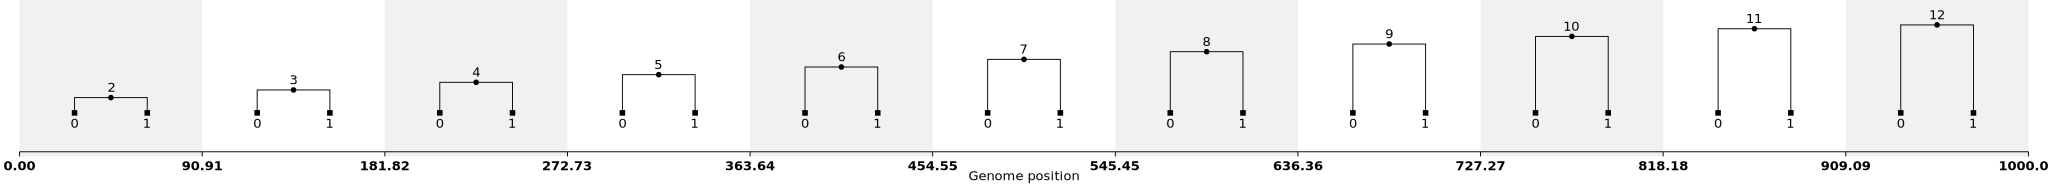

In [10]:
ts_stack = ts_stack.simplify()
ts_stack.draw_svg()

In [11]:
ts_stack.tables.edges

id,left,right,parent,child,metadata
0,0.00000000,90.90909091,2,0,
1,0.00000000,90.90909091,2,1,
2,90.90909091,181.81818182,3,0,
3,90.90909091,181.81818182,3,1,
4,181.81818182,272.72727273,4,0,
5,181.81818182,272.72727273,4,1,
6,272.72727273,363.63636364,5,0,
7,272.72727273,363.63636364,5,1,
8,363.63636364,454.54545455,6,0,
9,363.63636364,454.54545455,6,1,


In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq,amp):
    x = np.linspace(0, 2*np.pi)
    y = amp*np.sin(x * freq)
    plt.plot(x, y)

interact(plot_func, freq = widgets.FloatSlider(value=7.5, min=1, max=5.0, step=0.5), amp = widgets.FloatSlider(value=7.5, min=1, max=5.0, step=0.5))


interactive(children=(FloatSlider(value=5.0, description='freq', max=5.0, min=1.0, step=0.5), FloatSlider(valu…

<function __main__.plot_func(freq, amp)>